# EDA

## Data Loading

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

# --------------------------------------------------
# Data Loading
# --------------------------------------------------
df = pd.read_csv("cure_all_cancers_data_treatment.csv")

print("Dataset shape:", df.shape)
df.head()

# --------------------------------------------------
# Boolean feature encoding (representation choice)
# --------------------------------------------------
# For distance-based models, boolean indicators are
# encoded as 0/1 so that each mismatch contributes
# equally to distance. This does not modify data content.
bool_cols = df.select_dtypes(include="bool").columns
df[bool_cols] = df[bool_cols].astype(int)


Dataset shape: (418, 37)


## Data Shape

In [18]:
n_obs, n_features = df.shape
print(f"Number of observations: {n_obs}")
print(f"Number of features: {n_features}")

Number of observations: 418
Number of features: 37


## Label balance

Label counts:
 has_cancer
0    343
1     75
Name: count, dtype: int64

Label proportions:
 has_cancer
0    0.820574
1    0.179426
Name: proportion, dtype: float64


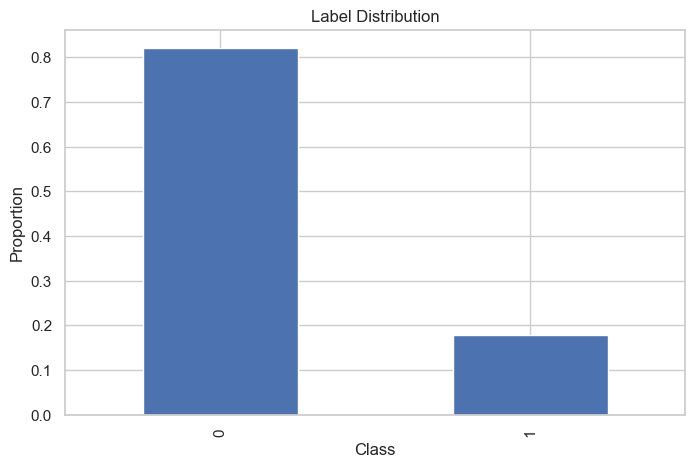

In [19]:
label_col = "has_cancer"

label_counts = df[label_col].value_counts()
label_props = df[label_col].value_counts(normalize=True)

print("Label counts:\n", label_counts)
print("\nLabel proportions:\n", label_props)

label_props.plot(kind="bar")
plt.title("Label Distribution")
plt.ylabel("Proportion")
plt.xlabel("Class")
plt.show()


## Missingness per feature

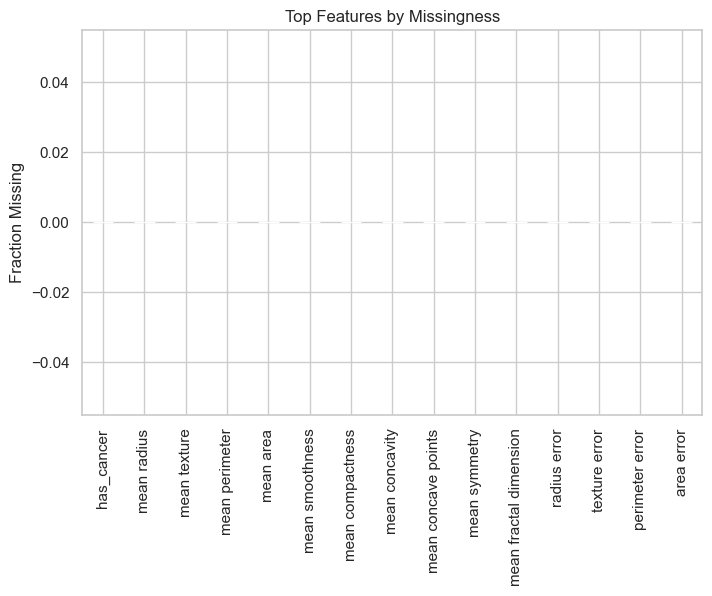

In [20]:
missing_pct = df.isna().mean().sort_values(ascending=False)

missing_summary = pd.DataFrame({
    "missing_fraction": missing_pct,
    "missing_count": df.isna().sum()
})

missing_summary

missing_pct.head(15).plot(kind="bar")
plt.title("Top Features by Missingness")
plt.ylabel("Fraction Missing")
plt.show()


## Feature distributions

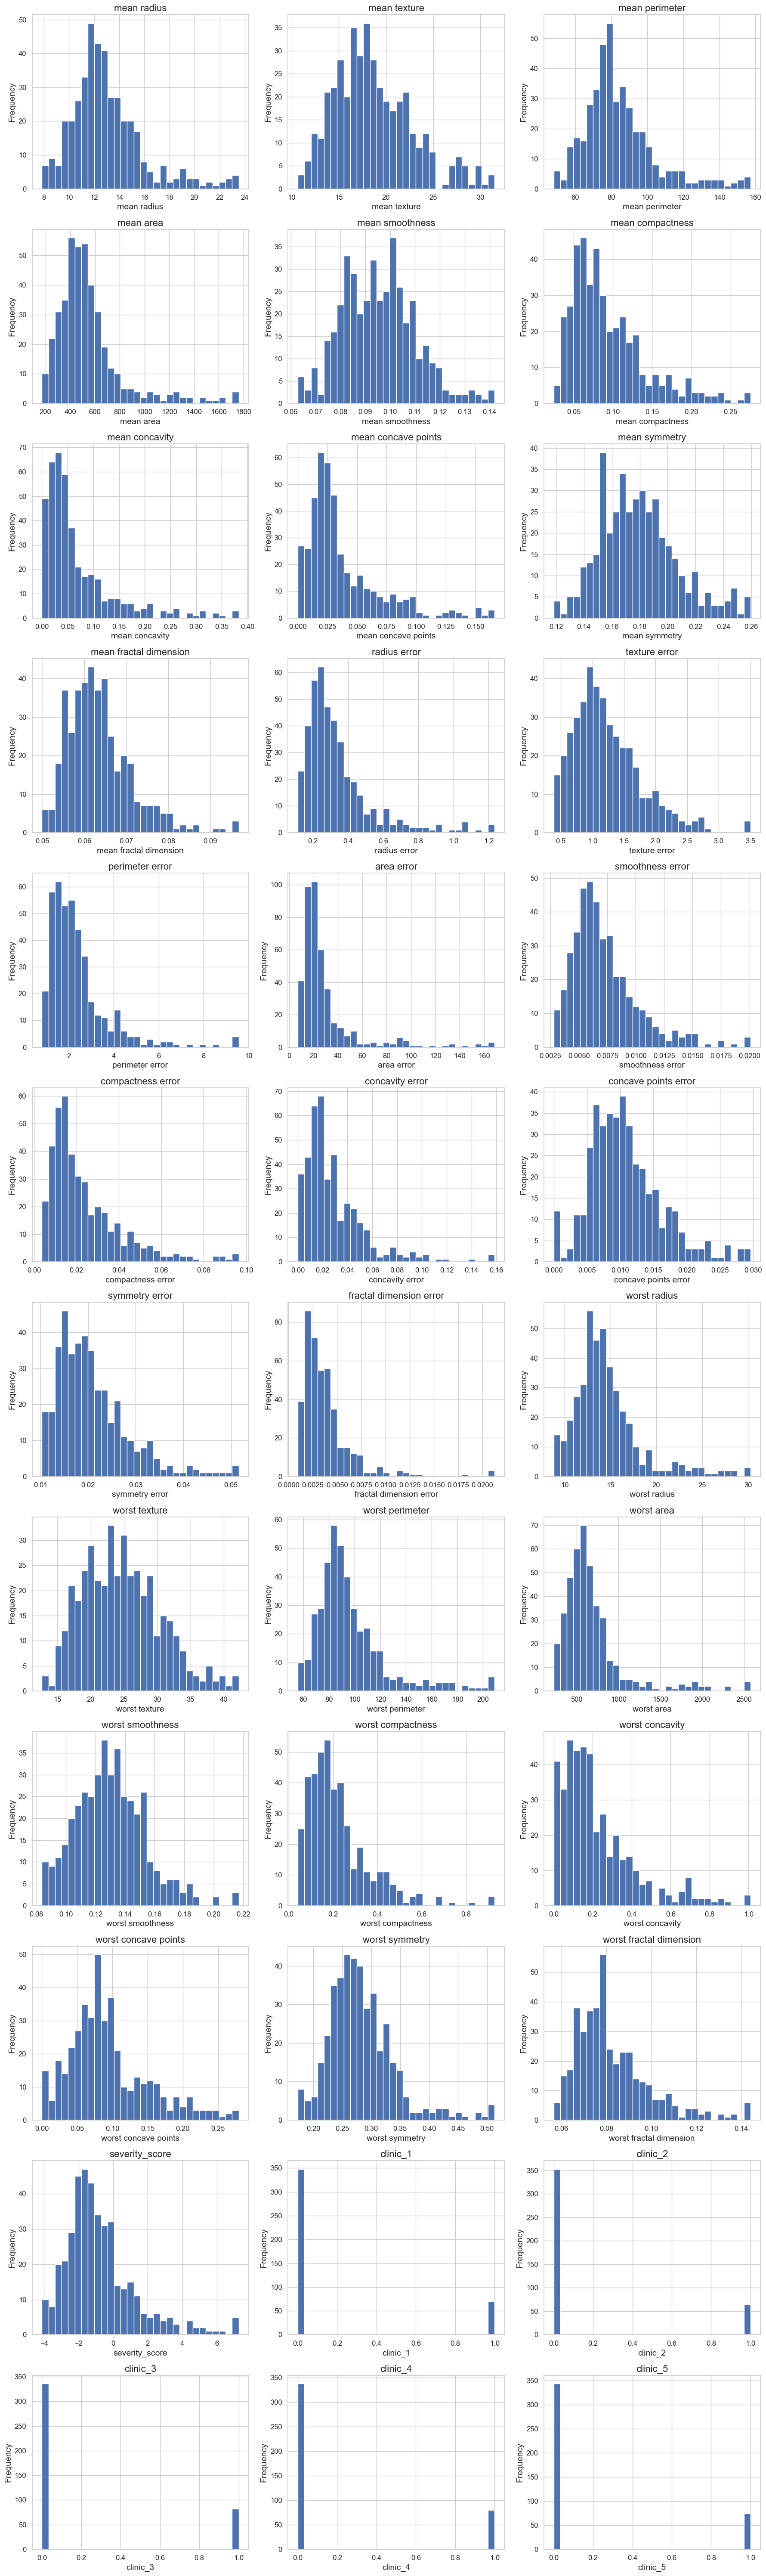

In [23]:
# --------------------------------------------------
# Global plotting configuration
# --------------------------------------------------
plt.rcParams.update({
    "figure.figsize": (14, 10),
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12
})

# Histograms in a grid
import math

numeric_features = df[feature_cols].select_dtypes(include="number").columns

n_cols = 3
n_rows = math.ceil(len(numeric_features) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

for ax, col in zip(axes, numeric_features):
    ax.hist(df[col], bins=30)
    ax.set_title(col)
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")

# Remove empty subplots
for ax in axes[len(numeric_features):]:
    ax.remove()

plt.tight_layout()
plt.show()


## Correlation heatmap

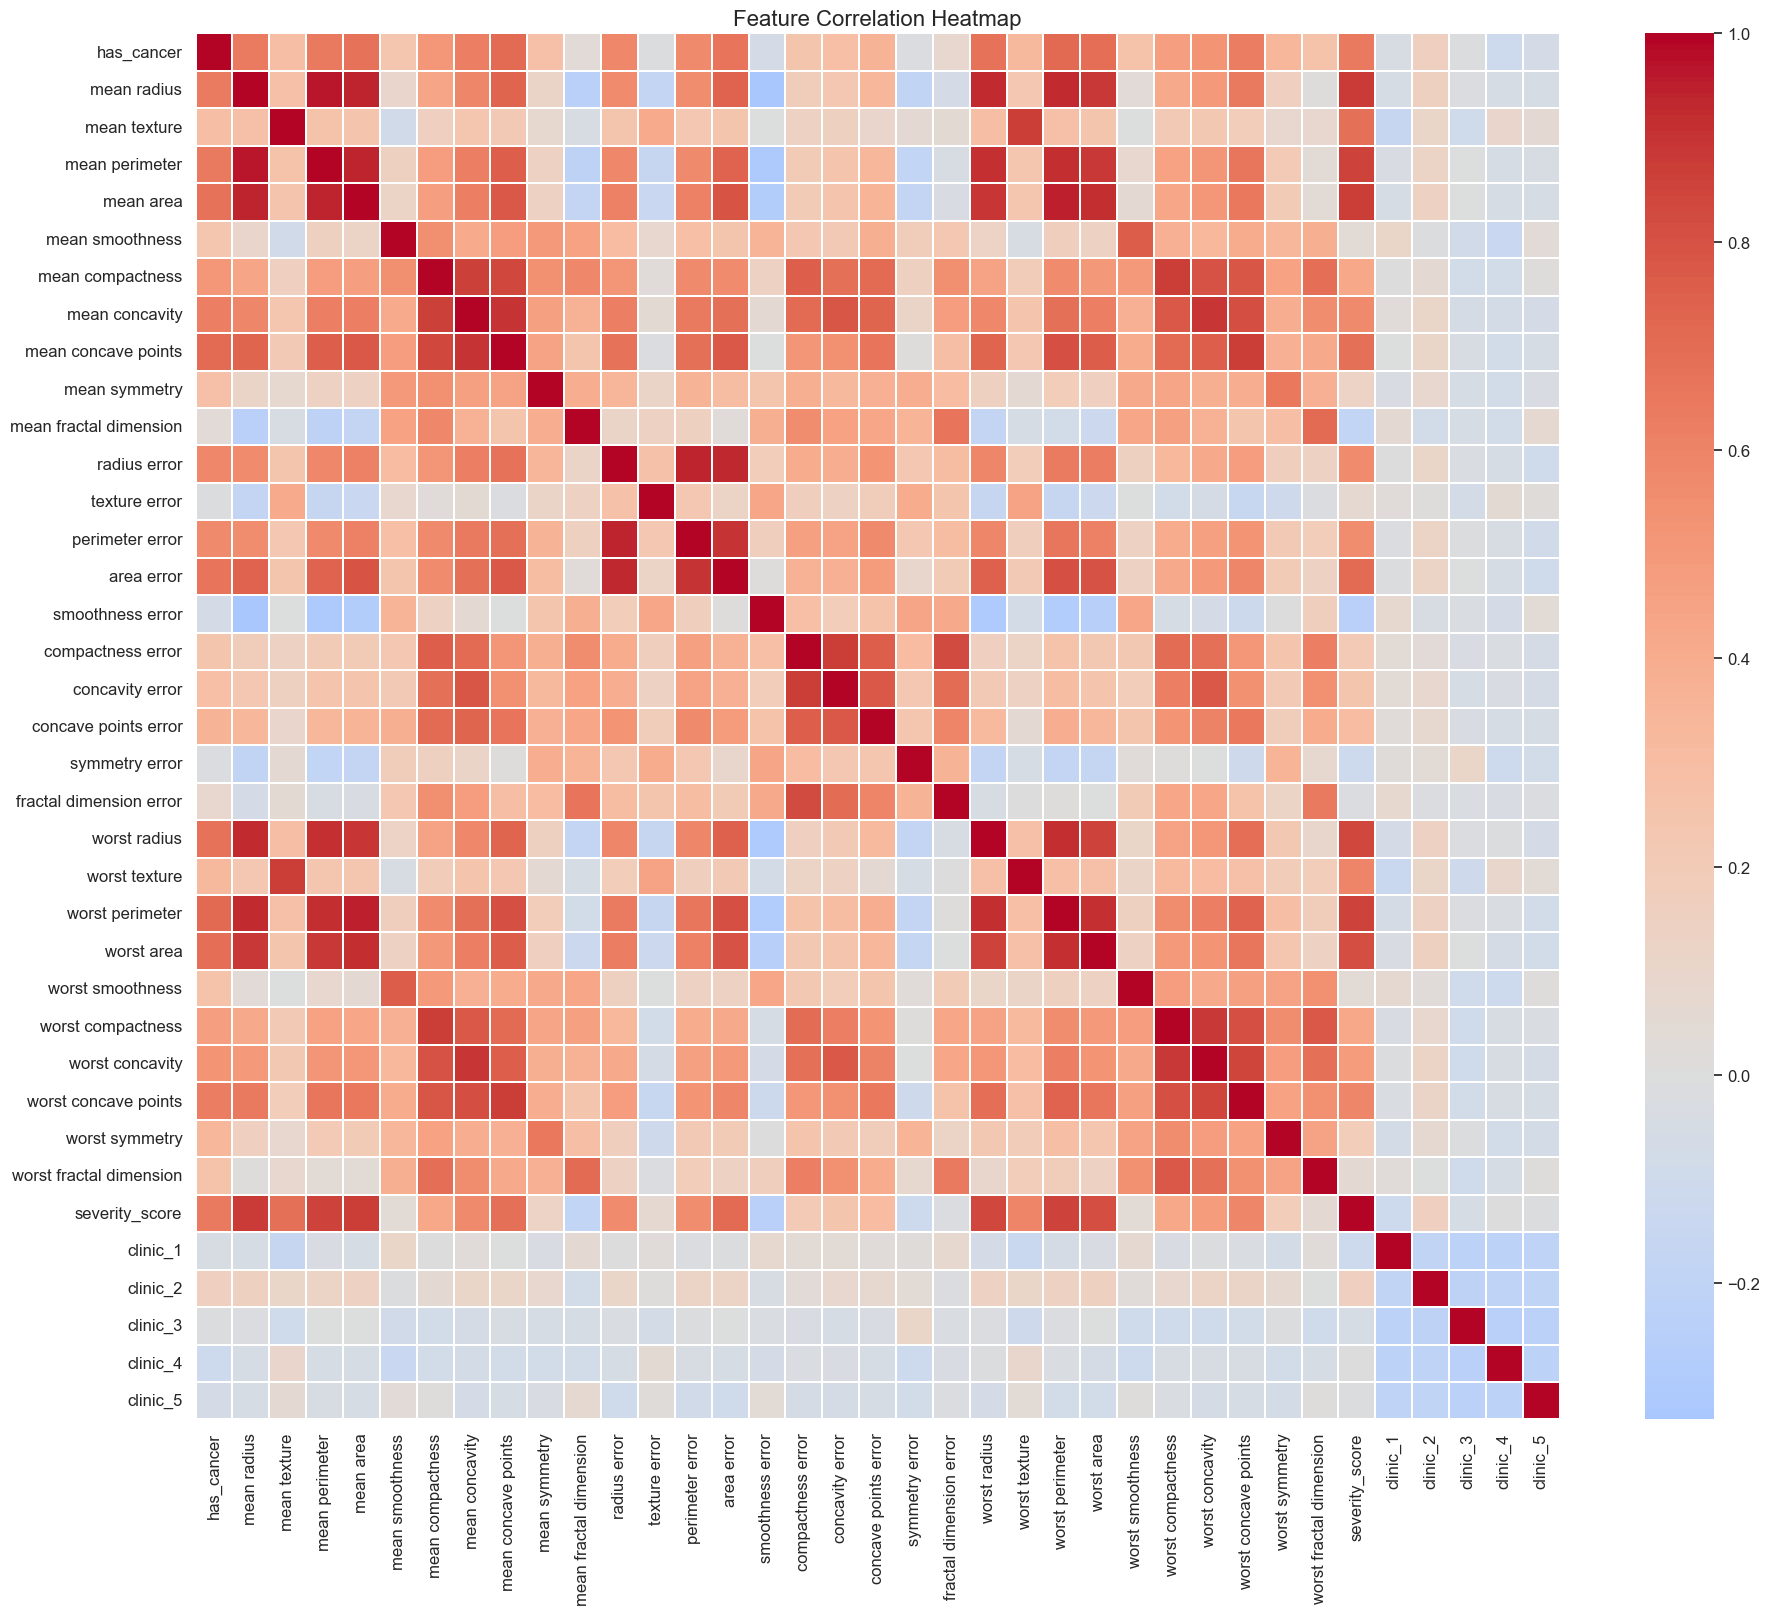

In [34]:
# --------------------------------------------------
# Global plotting configuration (easy to tune)
# --------------------------------------------------
PLOT_CONFIG = {
    "figsize": (22, 18),
    "title_size": 18,
    "tick_size": 18,
    "label_rotation_x": 90,
    "label_rotation_y": 0,
    "line_width": 0.3,
    "cbar_shrink": 0.8
}

corr_cols = ["has_cancer"] + feature_cols.tolist()
corr = df[corr_cols].corr()

plt.figure(figsize=PLOT_CONFIG["figsize"])
sns.heatmap(
    corr,
    cmap="coolwarm",
    center=0,
    linewidths=0.3
)
plt.title("Feature Correlation Heatmap")
plt.show()


# KNN Model

## Data Splitting

In [37]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, PowerTransformer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

# -----------------------------
# Load data (edit target name if needed)
# -----------------------------
df = pd.read_csv("cure_all_cancers_data_treatment.csv")

label_col = "has_cancer"
y = df[label_col]
X = df.drop(columns=[label_col])

# -----------------------------
# Train/test split (single holdout test set)
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # good for classification to preserve class balance
)


## Data Transformation
  - Exclude binary features
  - Log transformation
  - Yeo–Johnson
  - StandardScaler
  - SImple xample

In [40]:
# -----------------------------
# Column detection helpers (binary vs continuous)
# -----------------------------
def detect_binary_cols(df: pd.DataFrame):
    bin_cols = []
    for c in df.columns:
        if not np.issubdtype(df[c].dtype, np.number):
            continue
        vals = df[c].dropna().unique()
        if len(vals) == 2 and set(vals).issubset({0, 1}):
            bin_cols.append(c)
    return bin_cols

def detect_nonneg_skew_cols(df: pd.DataFrame, exclude_cols, skew_thresh=1.0):
    cols = []
    num_df = df.select_dtypes(include=[np.number])
    for c in num_df.columns:
        if c in exclude_cols:
            continue
        # Only safe for log/log1p if all values are >= 0
        if num_df[c].min(skipna=True) >= 0:
            sk = num_df[c].skew()
            if np.isfinite(sk) and abs(sk) > skew_thresh:
                cols.append(c)
    return cols

def detect_other_continuous_cols(df: pd.DataFrame, exclude_cols):
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    return [c for c in num_cols if c not in exclude_cols]

binary_cols = detect_binary_cols(X_train)
log_cols = detect_nonneg_skew_cols(X_train, exclude_cols=binary_cols, skew_thresh=1.0)
other_cont_cols = detect_other_continuous_cols(X_train, exclude_cols=binary_cols + log_cols)

print("Binary cols:", binary_cols)
print("Log1p cols (nonneg & skewed):", log_cols)
print("Yeo-Johnson cols (other numeric):", other_cont_cols)

# -----------------------------
# Preprocess: log1p for nonneg skewed, Yeo-Johnson for possibly-negative, z-score, keep binary
# -----------------------------
log1p_tf = FunctionTransformer(np.log1p, feature_names_out="one-to-one")

preprocess = ColumnTransformer(
    transformers=[
        ("bin", "passthrough", binary_cols),
        ("log1p", Pipeline([("log", log1p_tf), ("sc", StandardScaler())]), log_cols),
        ("yj", Pipeline([
            ("pt", PowerTransformer(method="yeo-johnson")),
            ("sc", StandardScaler())
        ]), other_cont_cols),
    ],
    remainder="drop"
)

pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("knn", KNeighborsClassifier())
])

# -----------------------------
# 5-fold CV on training set (no separate validation set)
# -----------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    "knn__n_neighbors": [3, 5, 7, 9, 11, 15, 21, 31],
    "knn__weights": ["uniform", "distance"],
    "knn__metric": ["minkowski"],
    "knn__p": [1, 2],  # 1=manhattan, 2=euclidean
}

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

grid.fit(X_train, y_train)

print("\nBest CV score (mean CV ROC AUC):", grid.best_score_)
print("Best params:", grid.best_params_)

best_model = grid.best_estimator_

# -----------------------------
# Performance comparison: TRAIN vs TEST
# -----------------------------
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix

# ---- TRAIN metrics ----
train_pred = best_model.predict(X_train)
print("\n===== TRAIN (on training data) =====")
print("Train Accuracy:", accuracy_score(y_train, train_pred))
print("Train Confusion matrix:\n", confusion_matrix(y_train, train_pred))
print(classification_report(y_train, train_pred, digits=3))

if hasattr(best_model, "predict_proba"):
    train_proba = best_model.predict_proba(X_train)[:, 1]
    print("Train ROC AUC:", roc_auc_score(y_train, train_proba))

# ---- TEST metrics ----
test_pred = best_model.predict(X_test)
print("\n===== TEST (held-out) =====")
print("Test Accuracy:", accuracy_score(y_test, test_pred))
print("Test Confusion matrix:\n", confusion_matrix(y_test, test_pred))
print(classification_report(y_test, test_pred, digits=3))

if hasattr(best_model, "predict_proba"):
    test_proba = best_model.predict_proba(X_test)[:, 1]
    print("Test ROC AUC:", roc_auc_score(y_test, test_proba))

# Show the CV std for the best setting
best_idx = grid.best_index_
print("\nBest setting CV ROC AUC mean ± std:",
      f"{grid.cv_results_['mean_test_score'][best_idx]:.4f} ± {grid.cv_results_['std_test_score'][best_idx]:.4f}")


Binary cols: []
Log1p cols (nonneg & skewed): ['mean radius', 'mean perimeter', 'mean area', 'mean compactness', 'mean concavity', 'mean concave points', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst perimeter', 'worst area', 'worst compactness', 'worst concavity', 'worst symmetry', 'worst fractal dimension']
Yeo-Johnson cols (other numeric): ['mean texture', 'mean smoothness', 'mean symmetry', 'concave points error', 'worst texture', 'worst smoothness', 'worst concave points', 'severity_score']
Fitting 5 folds for each of 32 candidates, totalling 160 fits

Best CV score (mean CV ROC AUC): 0.9542873176206509
Best params: {'knn__metric': 'minkowski', 'knn__n_neighbors': 31, 'knn__p': 1, 'knn__weights': 'distance'}

===== TRAIN (on training data) =====
Train Accuracy: 1.0
Train Confusion matrix:
 [[274   0]
 [  0  60

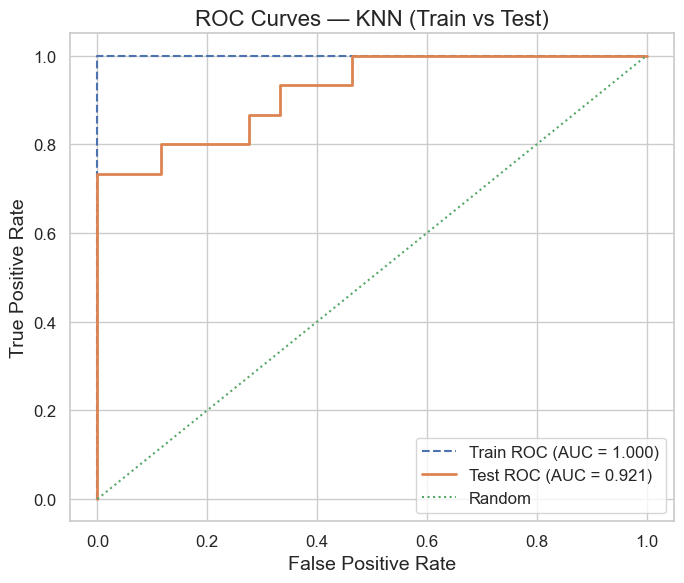

In [41]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# ---- Get predicted probabilities ----
train_proba = best_model.predict_proba(X_train)[:, 1]
test_proba  = best_model.predict_proba(X_test)[:, 1]

# ---- ROC curve points ----
fpr_train, tpr_train, _ = roc_curve(y_train, train_proba)
fpr_test,  tpr_test,  _ = roc_curve(y_test, test_proba)

# ---- AUC values ----
auc_train = roc_auc_score(y_train, train_proba)
auc_test  = roc_auc_score(y_test, test_proba)

# ---- Plot ----
plt.figure(figsize=(7, 6))

plt.plot(
    fpr_train, tpr_train,
    label=f"Train ROC (AUC = {auc_train:.3f})",
    linestyle="--"
)

plt.plot(
    fpr_test, tpr_test,
    label=f"Test ROC (AUC = {auc_test:.3f})",
    linewidth=2
)

# Diagonal (random classifier)
plt.plot([0, 1], [0, 1], linestyle=":", label="Random")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves — KNN (Train vs Test)")
plt.legend(loc="lower right")
plt.grid(True)

plt.tight_layout()
plt.show()


## Drop Features Exploratoin